In [7]:
import pandas as pd
import matplotlib.pyplot as plt

exp_path = "experiments/" + "simulated_perc_shortage_test_s0"
data = pd.read_csv(exp_path + "/simulated_data_shortage_output.csv")

In [8]:
data["optic_cup_performance"][0][11:-1] # cut out the "metatensor" from the saved string

disc_performance = [float(number[11:-1]) for number in data["optic_disc_performance"]]
cup_performance = [float(number[11:-1]) for number in data["optic_cup_performance"]]
percentages = [round(float(perc), 3) for perc in data["percentage"]]

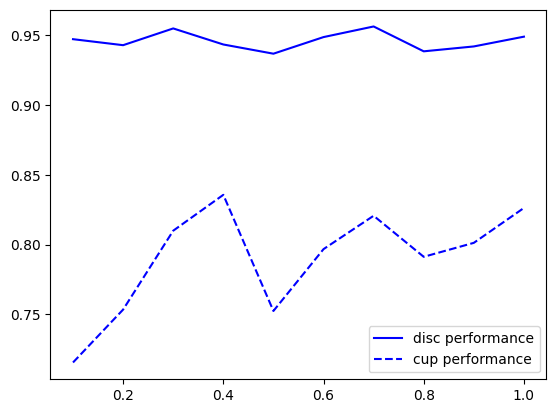

In [9]:
plt.plot(percentages, disc_performance, linestyle="-", color="b", label="disc performance")
plt.plot(percentages, cup_performance, linestyle="--", color="b", label="cup performance")
plt.legend()